In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License"); you may
# not use this file except in compliance with the License. You may obtain
# a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
# WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
# License for the specific language governing permissions and limitations
# under the License.

# Analyze Facebook Data Using IBM Watson and IBM Data Platform

This is a three-part notebook written in `Python_3.5` meant to show how anyone can enrich and analyze a combined dataset of unstructured and strucutured information with IBM Watson and IBM Data Platform. For this example we are using a standard Facebook Analytics export which features texts from posts, articles and thumbnails, along with standard performance metrics such as likes, shares, and impressions. 

**Part I** will use the Natual Language Understanding, Visual Recognition and Tone Analyzer Services from IBM Watson to enrich the Facebook Posts, Thumbnails, and Articles by pulling out `Emotion Tones`, `Social Tones`, `Language Tones`, `Entities`, `Keywords`, and `Document Sentiment`. The end result of Part I will be additional features and metrics we can test, analyze, and visualize in Part III. 

**Part II** will be used to set up the visualizations and tests we will run in Part III. The end result of Part II will be multiple Pandas DataFrames that will contain the values, and metrics needed to find insights from the Part III tests and experiments.

**Part III** will include services from IBM's Data Platform, including IBM's own data visualization library PixieDust. In Part III we will run analysis on the data from the Facebook Analytics export, such as the number of likes, comments, shares, to the overall reach for each post, and will compare it to the enriched data we pulled in Part I.


#### You should only need to change data in the Setup portion of this notebook. All places where you see  <span style="color: red"> User Input </span> is where you should be adding inputs. 

### Table of Contents

### [**Part I - Enrich**](#part1)<br>
1. [Setup](#setup)<br>
   1.1 [Install Watson Developer Cloud and BeautifulSoup Packages](#setup1)<br>
   1.2 [Install PixieDust](#pixie)<br> 
   1.3 [Import Packages and Libraries](#setup2)<br>
   1.4 [Add Service Credentials From Bluemix for Watson Services](#setup3)<br>
2. [Load Data](#load)<br>
   2.1 [Load Data From SoftLayer's Object Storage as a Pandas DataFrame](#load1)<br>
3. [Prepare Data](#prepare)<br>
   3.1 [Data Cleansing with Python](#prepare1)<br>
   3.2 [Beautiful Soup to Extract Thumbnails and Extented Links](#prepare2)<br>
4. [Enrich Data](#enrich)<br>
   4.1 [NLU for Post Text](#nlupost)<br>
   4.2 [NLU for Thumbnail Text](#nlutn)<br>
   4.3 [NLU for Article Text](#nlulink)<br>
   4.4 [Tone Analyzer for Post Text](#tonepost)<br>
   4.5 [Tone Analyzer for Article Text](#tonearticle)<br>
   4.6 [Visual Recognition](#visual)<br>
5. [Write Data](#write)<br>
   5.1 [Convert DataFrame to new CSV](#write1)<br>
   5.2 [Write Data to SoftLayer's Object Storage](#write2)<br>
    
### [**Part II - Data Preperation**](#part2)<br>
1. [Prepare Data](#prepare)<br>
   1.1 [Create Multiple DataFrames for Visualizations](#visualizations)<br>
   1.2 [Create A Consolidated Tone Dataframe](#tone)<br>
   1.3 [Create A Consolidated Keyword Dataframe](#keyword)<br>
   1.4 [Create A Consolidated Entity Dataframe](#entity)<br>
  
### [**Part III - Analyze**](#part3)<br>

1. [Setup](#2setup)<br> 
    1.1 [Assign Variables](#2setup2)<br>
2. [Load Data](#2load)<br>
    2.1 [Load Data From SoftLayer's Object Storage as a Spark SQL DataFrame](#2load1)<br>
3. [Visualize Data](#2visual)<br>
    3.1 [Run PixieDust Visualization Library with Display() API](#2visual2)
   
### Learn more about the technology used:

* [Natual Language Understanding](https://www.ibm.com/watson/developercloud/natural-language-understanding.html)
* [Tone Analyzer](https://www.ibm.com/watson/developercloud/tone-analyzer.html)
* [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)
* [PixieDust](https://github.com/ibm-cds-labs/pixiedust) (Part III)

### Sample Documents
1. [Sample Facebook Posts](https://ibm.box.com/s/25trtr37krt34s9swpxa1jb7fkd63ntm) - This is a sample export of IBM Watson's Facebook Page. Engagement metrics such as clicks, impressions, etc. are all changed and do not reflect any actual post performance data.


<a id="part1"></a>
#  Part I - Enrich


## 1. Setup
<a id="setup1"></a>
### 1.1 Install Latest Watson Developer Cloud and Beautiful Soup Packages

In [1]:
!pip install --upgrade watson-developer-cloud

Requirement already up-to-date: watson-developer-cloud in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages
Requirement already up-to-date: pysolr<4.0,>=3.3 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages (from watson-developer-cloud)
Requirement already up-to-date: requests<3.0,>=2.0 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages (from watson-developer-cloud)
Requirement already up-to-date: pyOpenSSL>=16.2.0 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages (from watson-developer-cloud)
Requirement already up-to-date: chardet<3.1.0,>=3.0.2 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages (from requests<3.0,>=2.0->watson-developer-cloud)
Requirement alre

In [2]:
!pip install --upgrade beautifulsoup4

Requirement already up-to-date: beautifulsoup4 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages


If WDC or BS4 was just installed or upgraded, <span style="color: red">restart the kernel</span> before continuing

<a id="pixie"></a>
### 1.2 Install PixieDust Library
This notebook provides an overview of how to use the PixieDust Library to analyze and visualize various data sets. If you are new to PixieDust or would like to learn more about the library, please go to this [Introductory Notebook](https://apsportal.ibm.com/exchange/public/entry/view/5b000ed5abda694232eb5be84c3dd7c1) or visit the [PixieDust Github](https://ibm-cds-labs.github.io/pixiedust/). The `Setup` section for this notebook uses instructions from the [Intro To PixieDust](https://github.com/ibm-cds-labs/pixiedust/blob/master/notebook/Intro%20to%20PixieDust.ipynb) notebook

To ensure you are running the latest version of PixieDust uncomment and run the following cell. Do not run this cell if you installed PixieDust locally from source and want to continue to run PixieDust from source.

In [3]:
!pip install --user --upgrade pixiedust

Requirement already up-to-date: pixiedust in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages
Requirement already up-to-date: lxml in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages (from pixiedust)
Requirement already up-to-date: geojson in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages (from pixiedust)
Requirement already up-to-date: mpld3 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages (from pixiedust)


<a id="setup2"></a>
### 1.3 Import Packages and Libraries
To check if you have package already installed, open new cell and write: *help.('Package Name')*

In [4]:
import json
import sys
import watson_developer_cloud
from watson_developer_cloud import ToneAnalyzerV3, VisualRecognitionV3
import watson_developer_cloud.natural_language_understanding.features.v1 as features

import operator
from functools import reduce
from io import StringIO
import numpy as np
from bs4 import BeautifulSoup as bs
from operator import itemgetter
from os.path import join, dirname
import pandas as pd
import numpy as np
import requests
import pixiedust

Pixiedust database opened successfully


<a id='setup3'></a>
### 1.4 Add Service Credentials From Bluemix for Watson Services

To create your own service and API keys for either NLU or Tone Analyzer go to the Watson Services on [Bluemix](https://www.ibm.com/cloud-computing/bluemix/).

After creating a service for NLU and Tone Analyzer, replace the credentials in the section below

###  <span style="color: red"> _User Input_</span> 

In [5]:
nlu = watson_developer_cloud.NaturalLanguageUnderstandingV1(version='2017-02-27',
                                                            username='User Input',
                                                            password='User Input')
tone_analyzer = ToneAnalyzerV3(version='2016-05-19',
                               username='User Input',
                               password='User Input')

visual_recognition = VisualRecognitionV3('2016-05-20', api_key='User Input')

<a id='load'></a> 
## 2. Load Data

### 2.1 Load data from Object Storage
IBM® Object Storage for Bluemix® provides provides you with access to a fully provisioned Swift Object Storage account to manage your data. Object Storage uses OpenStack Identity (Keystone) for authentication and can be accessed directly by using [OpenStack Object Storage (Swift) API v3](http://developer.openstack.org/api-ref-identity-v3.html#credentials-v3). 



###  <span style="color: red"> _User Input_</span> 

Insert data you want to enrich by clicking on the 1001 icon on the upper right hand of the screen. Click "Insert to code" under the file you want to enrich. The make sure you've clicked the cell below and then choose "Insert Pandas DataFrame."

In [47]:
# insert pandas dataframe


###  <span style="color: red"> _User Input_</span> 

In [7]:
#Make sure this equals the variable above.


###  <span style="color: red"> _User Input_</span> 

Put in the credentials for the file you want to enrich by clicking on the 1001 icon on the upper right hand of the screen. Click the cell below, then click "Insert to code" under the file you want to enrich. Choose "Insert Credentials." **CHANGE THE NAME TO `credentials_1`**

In [8]:
#insert credentials for file - Change to credentials_1


###  <span style="color: red"> _User Input_</span> 

In [9]:
#choose any name to save your file
localfilename = 'OutputFile.csv'

<a id='prepare'></a>
## 3. Prepare Data



<a id='prepare1'></a>
###  3.1 Data Cleansing with Python
Renaming columns, removing noticable noise in the data, pulling out URLs and appending to a new column to run through NLU

In [10]:
df.rename(columns={'Post Message': 'Text'}, inplace=True)

In [11]:
df = df.drop([0])
#df.head()

In [12]:
df_http= df["Text"].str.partition("http")
df_www = df["Text"].str.partition("www")

#combine delimiters with actual links
df_http["Link"] = df_http[1].map(str) + df_http[2]
df_www["Link1"] = df_www[1].map(str) + df_www[2]

#include only Link columns 
df_http.drop(df_http.columns[0:3], axis=1, inplace = True)
df_www.drop(df_www.columns[0:3], axis=1, inplace = True)

#merge http and www dataframes
dfmerge = pd.concat([df_http, df_www], axis=1)

#the following steps will allow you to merge data columns from the left to the right
dfmerge = dfmerge.apply(lambda x: x.str.strip()).replace('', np.nan)

#use fillna to fill any blanks with the Link1 column
dfmerge["Link"].fillna(dfmerge["Link1"], inplace = True)

#delete Link1 (www column)
dfmerge.drop("Link1", axis=1, inplace = True)

#combine Link data frame 
df = pd.concat([dfmerge,df], axis = 1)

# # make sure text column is a string
df["Text"] = df["Text"].astype("str")

# #strip links from Text column
df['Text'] = df['Text'].apply(lambda x: x.split('http')[0])
df['Text'] = df['Text'].apply(lambda x: x.split('www')[0])

#df.head()

In [13]:
#Pull thumbnail descriptions using beautiful soup
#changes links from objects to strings
for link in df.Link:
    df.Link.to_string()
    
#create empty list to store descriptions    
description = []

#use BeautifulSoup to pull descriptions from links 
for url in df["Link"]:
    try:
        #if there's no description
        if pd.isnull(url):
            description.append("")
        else:
            page3= requests.get(url)
            soup3= bs(page3.text,"lxml")
            #Capture both capatalized 'Description' and lower case
            desc= soup3.find(attrs={'name':'Description'})
            if desc == None:
                desc= soup3.find(attrs={'name':'description'})
            description.append(desc['content'])
            
    #this exception will save you from 404 errors
    except Exception:
        description.append("")
        continue
        
#save to df and add column titled 'Thumbnails'
df["Thumbnails"] = description
#df['Thumbnails'].head()
#df.head()

In [14]:
piclinks = []

for url in df["Link"]:
    try:
        if pd.isnull(url):
            piclinks.append("")
        else: 
            page3= requests.get(url)
            soup3= bs(page3.text,"lxml")
            pic = soup3.find('meta', property ="og:image")
            if pic:
                piclinks.append(pic["content"])
            else: 
                piclinks.append("")
    except:
        piclinks.append("")
df["Image"] = piclinks 

**<span style="color: red">Optional<span>**: Convert shortened links to full links (Note: NLU requires full links)
Use requests module to pull extended lists. This is only necessary if the Facebook page uses different links than the articles themselves. For this example we are using IBM Watson's Facebook export which uses an IBM link. 


In [15]:
#converts shortened links to their original form

shortlink = df["Link"]
extendedlink = []

for link in shortlink:
    #create empty list to store   
    try:
        extended_link = requests.Session().head(link, allow_redirects=True).url
        extendedlink.append(extended_link)
    except:
         # catch *all* exceptions
        e = sys.exc_info()[0]
        extendedlink.append('')
        pass
df["Extended Links"] = extendedlink

<a id='enrich'></a> 
## 4. Enrichment Time!
<a id='nlupost'></a>
###  4.1 NLU for the Post Text
Below uses Natural Language Understanding to iterate through each post and extract the enrichment features we want to use in our future analysis.

Each feature we extract will be appended to the `.csv` in a new column we determine at the end of this script. If you want to run this same script for the other columns, define `free_form_responses` to the column name, if you are using URLs, change `text=response` parameter to `url=response`, and update the new column names as you see fit. 

In [16]:
# Extract the free form text response from the data frame
# If you are using this script for a diff CSV, you will have to change this column name
free_form_responses = df['Text']
# define the list of enrichments to apply
# if you are modifying this script add or remove the enrichments as needed
f = [features.Entities(), features.Keywords(),features.Emotion(),features.Sentiment()]#'typed-rels'

# Create a list to store the enriched data
overallSentimentScore = []
overallSentimentType = []
highestEmotion = []
highestEmotionScore = []
kywords = []
entities = []

# Go thru every reponse and enrich the text using NLU
for idx, response in enumerate(free_form_responses):
    #print("Processing record number: ", idx, " and text: ", response)
    try:
        enriched_json = json.loads(json.dumps(nlu.analyze(text=response, features=f)))
        #print(enriched_json)

        # get the SENTIMENT score and type
        if 'sentiment' in enriched_json:
            if('score' in enriched_json['sentiment']["document"]):
                overallSentimentScore.append(enriched_json["sentiment"]["document"]["score"])
            else:
                overallSentimentScore.append('0')

            if('label' in enriched_json['sentiment']["document"]):
                overallSentimentType.append(enriched_json["sentiment"]["document"]["label"])
            else:
                overallSentimentType.append('0')

        # read the EMOTIONS into a dict and get the key (emotion) with maximum value
        if 'emotion' in enriched_json:
            me = max(enriched_json["emotion"]["document"]["emotion"].items(), key=operator.itemgetter(1))[0]
            highestEmotion.append(me)
            highestEmotionScore.append(enriched_json["emotion"]["document"]["emotion"][me])

        else:
            highestEmotion.append("")
            highestEmotionScore.append("")

        #iterate and get KEYWORDS with a confidence of over 50%
        if 'keywords' in enriched_json:
            #print((enriched_json['keywords']))
            tmpkw = []
            for kw in enriched_json['keywords']:
                if(float(kw["relevance"]) >= 0.5):
                    #print("kw is: ", kw, "and val is ", kw["text"])
                    tmpkw.append(kw["text"])#str(kw["text"]).strip('[]')
            #convert multiple keywords in a list to a string
            if(len(tmpkw) > 1):
                tmpkw = "".join(reduce(lambda a, b: a + ', ' + b, tmpkw))
            elif(len(tmpkw) == 0):
                tmpkw = ""
            else:
                tmpkw = "".join(reduce(lambda a, b='': a + b , tmpkw))
            kywords.append(tmpkw)
        else:
            kywords.append("")
            
        #iterate and get Entities with a confidence of over 30%
        if 'entities' in enriched_json:
            #print((enriched_json['entities']))
            tmpent = []
            for ent in enriched_json['entities']:
                
                if(float(ent["relevance"]) >= 0.3):
                    tmpent.append(ent["type"])
            #convert multiple concepts in a list to a string
            if(len(tmpent) > 1):
                tmpent = "".join(reduce(lambda a, b: a + ', ' + b, tmpent))
            elif(len(tmpent) == 0):
                tmpent = ""
            else:
                tmpent = "".join(reduce(lambda a, b='': a + b , tmpent))
            entities.append(tmpent)
        else:
            entities.append("")    
            
    except:
        # catch *all* exceptions
        e = sys.exc_info()[0]
        overallSentimentScore.append(' ')
        overallSentimentType.append(' ')
        highestEmotion.append(' ')
        highestEmotionScore.append(' ')
        kywords.append(' ')
        entities.append(' ')
        pass
    
# Create columns from the list and append to the dataframe
if highestEmotion:
    df['TextHighestEmotion'] = highestEmotion
if highestEmotionScore:
    df['TextHighestEmotionScore'] = highestEmotionScore

if overallSentimentType:
    df['TextOverallSentimentType'] = overallSentimentType
if overallSentimentScore:
    df['TextOverallSentimentScore'] = overallSentimentScore

df['TextKeywords'] = kywords
df['TextEntities'] = entities

After we extract all of the Keywords and Entities from each Post, we have a column with multiple Keywords, and Entities separated by commas. For our Analysis in Part II we wanted also wanted the top Keyword and Entity for each Post. Because of this, we added two new columns to capture the `MaxTextKeyword` and `MaxTextEntity`

In [17]:
#choose first of Keywords,Concepts, Entities
df["MaxTextKeywords"] = df["TextKeywords"].apply(lambda x: x.split(',')[0])
df["MaxTextEntity"] = df["TextEntities"].apply(lambda x: x.split(',')[0])
#df.head()

<a id='nlutn'></a>
###  4.2 NLU for Thumbnail Text

We will repeat the same process for Thumbnails and Article Text.

In [18]:
# Extract the thumbnail text from the data frame
# If you are using this script for a diff CSV, you will have to change this column name
free_form_responses= df['Thumbnails']
# define the list of enrichments to apply
# if you are modifying this script add or remove the enrichments as needed
f = [features.Entities(), features.Keywords(),features.Emotion(),features.Sentiment()]#'typed-rels'

# Create a list to store the enriched data
overallSentimentScore = []
overallSentimentType = []
highestEmotion = []
highestEmotionScore = []
kywords = []
entities = []


# Go thru every reponse and enrich the text using NLU
for idx, response in enumerate(free_form_responses):
    #print("Processing record number: ", idx, " and text: ", response)
    try:
        enriched_json = json.loads(json.dumps(nlu.analyze(text=response, features=f)))
        #print(enriched_json)

        # get the SENTIMENT score and type
        if 'sentiment' in enriched_json:
            if('score' in enriched_json['sentiment']["document"]):
                overallSentimentScore.append(enriched_json["sentiment"]["document"]["score"])
            else:
                overallSentimentScore.append("")

            if('label' in enriched_json['sentiment']["document"]):
                overallSentimentType.append(enriched_json["sentiment"]["document"]["label"])
            else:
                overallSentimentType.append("")

        # read the EMOTIONS into a dict and get the key (emotion) with maximum value
        if 'emotion' in enriched_json:
            me = max(enriched_json["emotion"]["document"]["emotion"].items(), key=operator.itemgetter(1))[0]
            highestEmotion.append(me)
            highestEmotionScore.append(enriched_json["emotion"]["document"]["emotion"][me])

        else:
            highestEmotion.append("")
            highestEmotionScore.append("")

        #iterate and get KEYWORDS with a confidence of over 50%
        if 'keywords' in enriched_json:
            #print((enriched_json['keywords']))
            tmpkw = []
            for kw in enriched_json['keywords']:
                if(float(kw["relevance"]) >= 0.5):
                    #print("kw is: ", kw, "and val is ", kw["text"])
                    tmpkw.append(kw["text"])#str(kw["text"]).strip('[]')
            #convert multiple keywords in a list to a string
            if(len(tmpkw) > 1):
                tmpkw = "".join(reduce(lambda a, b: a + ', ' + b, tmpkw))
            elif(len(tmpkw) == 0):
                tmpkw = ""
            else:
                tmpkw = "".join(reduce(lambda a, b='': a + b , tmpkw))
            kywords.append(tmpkw)

            
        #iterate and get Entities with a confidence of over 30%
        if 'entities' in enriched_json:
            #print((enriched_json['entities']))
            tmpent = []
            for ent in enriched_json['entities']:
                
                if(float(ent["relevance"]) >= 0.3):
                    tmpent.append(ent["type"])
            #convert multiple concepts in a list to a string
            if(len(tmpent) > 1):
                tmpent = "".join(reduce(lambda a, b: a + ', ' + b, tmpent))
            elif(len(tmpent) == 0):
                tmpent = ""
            else:
                tmpent = "".join(reduce(lambda a, b='': a + b , tmpent))
            entities.append(tmpent)
        else:
            entities.append("")  
    
            
    except:
        # catch *all* exceptions
        e = sys.exc_info()[0]
        overallSentimentScore.append(' ')
        overallSentimentType.append(' ')
        highestEmotion.append(' ')
        highestEmotionScore.append(' ')
        kywords.append(' ')
        entities.append(' ')
        pass

# print(len(highestEmotion))
# print(len(highestEmotionScore))
# print(len(overallSentimentType))
# print(len(overallSentimentScore))
# print(len(kywords))
# print(len(entities))
    
# Create columns from the list and append to the dataframe
if highestEmotion:
    df['ThumbnailHighestEmotion'] = highestEmotion
if highestEmotionScore:
    df['ThumbnailHighestEmotionScore'] = highestEmotionScore

if overallSentimentType:
    df['ThumbnailOverallSentimentType'] = overallSentimentType
if overallSentimentScore:
    df['ThumbnailOverallSentimentScore'] = overallSentimentScore

df['ThumbnailKeywords'] = kywords
df['ThumbnailEntities'] = entities

In [19]:
#choose first of Keywords,Concepts,Entities
df["MaxThumbnailKeywords"] = df["ThumbnailKeywords"].apply(lambda x: x.split(',')[0])
df["MaxThumbnailEntity"] = df["ThumbnailEntities"].apply(lambda x: x.split(',')[0])
#df.head()

<a id='nlulink'></a> 
### 4.3 NLU for Article Text

In [20]:
# Run links through NLU and return Titles, and NLU Enrichment on full articles
# If you are using this script for a diff CSV, you will have to change this column name
free_form_responses = df['Extended Links']
# define the list of enrichments to apply
# if you are modifying this script add or remove the enrichments as needed
f = [features.Entities(), features.Keywords(),features.Emotion(),features.Sentiment()]#'typed-rels'

# Create a list to store the enriched data
overallSentimentScore = []
overallSentimentType = []
highestEmotion = []
highestEmotionScore = []
kywords = []
entities = []



        
# Go thru every reponse and enrich the text using NLU
for idx, response in enumerate(free_form_responses):
    #print("Processing record number: ", idx, " and text: ", response)
    try:
        enriched_json = json.loads(json.dumps(nlu.analyze(url=response, features=f)))
        #print(enriched_json)

        # get the SENTIMENT score and type
        if 'sentiment' in enriched_json:
            if('score' in enriched_json['sentiment']["document"]):
                overallSentimentScore.append(enriched_json["sentiment"]["document"]["score"])
            else:
                overallSentimentScore.append('None')

            if('label' in enriched_json['sentiment']["document"]):
                overallSentimentType.append(enriched_json["sentiment"]["document"]["label"])
            else:
                overallSentimentType.append('')

        # read the EMOTIONS into a dict and get the key (emotion) with maximum value
        if 'emotion' in enriched_json:
            me = max(enriched_json["emotion"]["document"]["emotion"].items(), key=operator.itemgetter(1))[0]
            highestEmotion.append(me)
            highestEmotionScore.append(enriched_json["emotion"]["document"]["emotion"][me])

        else:
            highestEmotion.append('')
            highestEmotionScore.append('')

        #iterate and get KEYWORDS with a confidence of over 50%
        if 'keywords' in enriched_json:
            #print((enriched_json['keywords']))
            tmpkw = []
            for kw in enriched_json['keywords']:
                if(float(kw["relevance"]) >= 0.5):
                    #print("kw is: ", kw, "and val is ", kw["text"])
                    tmpkw.append(kw["text"])#str(kw["text"]).strip('[]')
            #convert multiple keywords in a list to a string
            if(len(tmpkw) > 1):
                tmpkw = "".join(reduce(lambda a, b: a + ', ' + b, tmpkw))
            elif(len(tmpkw) == 0):
                tmpkw = ""
            else:
                tmpkw = "".join(reduce(lambda a, b='': a + b , tmpkw))
            kywords.append(tmpkw)
        else: 
            kywords.append("")
            
        #iterate and get Entities with a confidence of over 30%
        if 'entities' in enriched_json:
            #print((enriched_json['entities']))
            tmpent = []
            for ent in enriched_json['entities']:
                
                if(float(ent["relevance"]) >= 0.3):
                    tmpent.append(ent["type"])
            #convert multiple concepts in a list to a string
            if(len(tmpent) > 1):
                tmpent = "".join(reduce(lambda a, b: a + ', ' + b, tmpent))
            elif(len(tmpent) == 0):
                tmpent = ""
            else:
                tmpent = "".join(reduce(lambda a, b='': a + b , tmpent))
            entities.append(tmpent)
        else:
            entities.append("")
    
            
    except:
        # catch *all* exceptions
        e = sys.exc_info()[0]
        overallSentimentScore.append(' ')
        overallSentimentType.append(' ')
        highestEmotion.append(' ')
        highestEmotionScore.append(' ')
        kywords.append(' ')
#       concepts.append(' ')
        entities.append(' ')

        pass

# print(len(highestEmotion))
# print(len(highestEmotionScore))
# print(len(overallSentimentType))
# print(len(overallSentimentScore))
# print(len(kywords))

# print(len(entities))
    
# Create columns from the list and append to the dataframe
if highestEmotion:
    df['LinkHighestEmotion'] = highestEmotion
if highestEmotionScore:
    df['LinkHighestEmotionScore'] = highestEmotionScore

if overallSentimentType:
    df['LinkOverallSentimentType'] = overallSentimentType
if overallSentimentScore:
    df['LinkOverallSentimentScore'] = overallSentimentScore

df['LinkKeywords'] = kywords
# df['TextConcepts'] = concepts
df['LinkEntities'] = entities


In [21]:
df["MaxLinkKeywords"] = df["LinkKeywords"].apply(lambda x: x.split(',')[0])
df["MaxLinkEntity"] = df["LinkEntities"].apply(lambda x: x.split(',')[0])
#df.head()

 <a id='tonepost'></a> 
### 4.4 Tone Analyzer for Post Text

In [22]:
# Extract the free form text response from the data frame
# If you are using this script for a diff CSV, you will have to change this column name
free_form_responses = df['Text']

#Create a list to store the enriched data

highestEmotionTone = []
emotionToneScore = []

languageToneScore = []
highestLanguageTone = []

socialToneScore = []
highestSocialTone = []


for idx, response in enumerate(free_form_responses):
    #print("Processing record number: ", idx, " and text: ", response)
    try:
        enriched_json = json.loads(json.dumps(tone_analyzer.tone(text=response)))
        #print(enriched_json)
        
        if 'tone_categories' in enriched_json['document_tone']:
            me = max(enriched_json["document_tone"]["tone_categories"][0]["tones"], key = itemgetter('score'))['tone_name']      
            highestEmotionTone.append(me)
            you = max(enriched_json["document_tone"]["tone_categories"][0]["tones"], key = itemgetter('score'))['score']
            emotionToneScore.append(you)
            
            me1 = max(enriched_json["document_tone"]["tone_categories"][1]["tones"], key = itemgetter('score'))['tone_name']      
            highestLanguageTone.append(me1)
            you1 = max(enriched_json["document_tone"]["tone_categories"][1]["tones"], key = itemgetter('score'))['score']
            languageToneScore.append(you1)
            
            me2 = max(enriched_json["document_tone"]["tone_categories"][2]["tones"], key = itemgetter('score'))['tone_name']      
            highestSocialTone.append(me2)
            you2 = max(enriched_json["document_tone"]["tone_categories"][2]["tones"], key = itemgetter('score'))['score']
            socialToneScore.append(you2)
            
            
            
    except:
        # catch *all* exceptions
        e = sys.exc_info()[0]
        emotionToneScore.append(' ')
        highestEmotionTone.append(' ')
        languageToneScore.append(' ')
        highestLanguageTone.append(' ')
        socialToneScore.append(' ')
        highestSocialTone.append(' ')
        pass
    
if highestEmotionTone:
    df['highestEmotionTone'] = highestEmotionTone    
if emotionToneScore:
    df['emotionToneScore'] = emotionToneScore
    
if languageToneScore:
    df['languageToneScore'] = languageToneScore
if highestLanguageTone:
    df['highestLanguageTone'] = highestLanguageTone
    
if highestSocialTone:
    df['highestSocialTone'] = highestSocialTone    
if socialToneScore:
    df['socialToneScore'] = socialToneScore 
    
#df.head()

<a id='enrich2'></a> 
### 4.5 Tone Analyzer for Article Text

Unlike NLU, Tone Analyzer cannot iterate through a URL so here we use NLU to pull the Article Text from the URL and append it to the original dataframe. 

To do this, we pull out the `MetaData` feature, and make sure the `return_analyzed_text` parameter is set to `True`. 

In [23]:
# Extract the free form text response from the data frame
# If you are using this script for a diff CSV, you will have to change this column name
free_form_responses = df['Link']
# define the list of enrichments to apply
# if you are modifying this script add or remove the enrichments as needed
f = [features.MetaData()]#'typed-rels'
article_text = []


for idx, response in enumerate(free_form_responses):
    try:
        enriched_json = json.loads(json.dumps(nlu.analyze(url=response, features=f,return_analyzed_text=True)))
        #print(enriched_json)
        article_text.append(enriched_json["analyzed_text"])
    except:
    
        article_text.append("")
        
#save to dataframe
df["Article Text"] = article_text
#df.head()

Similar to the script for NLU, we are now using Tone Analyzer to iterate through the newly created and appended `Article Text` column which contains all of the free form text from the articles contained in the Facebook posts. 

We are using Tone Analyzer to gather the tope Social, Writing and Emotion Tones from the Articles and appending them, along with their respective scores to the `.csv`

In [24]:
# Extract the free form text response from the data frame
# If you are using this script for a diff CSV, you will have to change this column name
free_form_responses = df['Article Text']

#Create a list to store the enriched data

highestEmotionTone = []
emotionToneScore = []

languageToneScore = []
highestLanguageTone = []

socialToneScore = []
highestSocialTone = []


for idx, response in enumerate(free_form_responses):
    #print("Processing record number: ", idx, " and text: ", response)
    try:
        enriched_json = json.loads(json.dumps(tone_analyzer.tone(text=response)))
        #print(enriched_json)
        
        if 'tone_categories' in enriched_json['document_tone']:
            maxTone = max(enriched_json["document_tone"]["tone_categories"][0]["tones"], key = itemgetter('score'))['tone_name']      
            highestEmotionTone.append(maxTone)
            maxToneScore = max(enriched_json["document_tone"]["tone_categories"][0]["tones"], key = itemgetter('score'))['score']
            emotionToneScore.append(maxToneScore)
            
            maxLanguageTone = max(enriched_json["document_tone"]["tone_categories"][1]["tones"], key = itemgetter('score'))['tone_name']      
            highestLanguageTone.append(maxLanguageTone)
            maxLanguageScore = max(enriched_json["document_tone"]["tone_categories"][1]["tones"], key = itemgetter('score'))['score']
            languageToneScore.append(maxLanguageScore)
            
            maxSocial = max(enriched_json["document_tone"]["tone_categories"][2]["tones"], key = itemgetter('score'))['tone_name']      
            highestSocialTone.append(maxSocial)
            maxSocialScore = max(enriched_json["document_tone"]["tone_categories"][2]["tones"], key = itemgetter('score'))['score']
            socialToneScore.append(maxSocialScore)
            
    except:
        # catch *all* exceptions
        e = sys.exc_info()[0]
        emotionToneScore.append(' ')
        highestEmotionTone.append(' ')
        
        languageToneScore.append(' ')
        highestLanguageTone.append(' ')
        
        socialToneScore.append(' ')
        highestSocialTone.append(' ')
        
        pass
    
if highestEmotionTone:
    df['articlehighestEmotionTone'] = highestEmotionTone    
if emotionToneScore:
    df['articleEmotionToneScore'] = emotionToneScore  
if languageToneScore:
    df['articlelanguageToneScore'] = languageToneScore
if highestLanguageTone:
    df['articlehighestLanguageTone'] = highestLanguageTone   
if highestSocialTone:
    df['articlehighestSocialTone'] = highestSocialTone    
if socialToneScore:
    df['articlesocialToneScore'] = socialToneScore 

#df.head()

In [25]:
df.head()

,Link,Post ID,Permalink,Text,Type,Countries,Languages,Posted,Audience Targeting,Lifetime Post Total Reach,...,highestLanguageTone,highestSocialTone,socialToneScore,Article Text,articlehighestEmotionTone,articleEmotionToneScore,articlelanguageToneScore,articlehighestLanguageTone,articlehighestSocialTone,articlesocialToneScore
1,NaN,187446750783_10153359024455784,https://www.facebook.com/ibmwatson/posts/10153...,Cheers to a wonderful New Year with Chef Watso...,Photo,NaN,NaN,12/31/15 6:28,,2291,...,Tentative,Extraversion,0.932799,,,,,,,
2,NaN,187446750783_10153215851080784,https://www.facebook.com/ibmwatson/posts/10153...,IBM Watson's cover photo,Photo,NaN,NaN,12/31/15 6:26,,158,...,Analytical,Agreeableness,0.625895,,,,,,,
3,http://ibm.co/1mngjQu,187446750783_10153357233820784,https://www.facebook.com/ibmwatson/posts/10153...,What is Watson? IBM Watson is a technology pla...,Photo,NaN,NaN,12/30/15 7:00,,4203,...,Analytical,Extraversion,0.769130,"with Watson \t\t\t\t\t\t\t\nWith Watson, you h...",Joy,0.574071,0.872652,Analytical,Extraversion,0.85401
4,http://ibm.co/1OWPPTh,187446750783_10153355476175784,https://www.facebook.com/ibmwatson/posts/10153...,"Your new personal shopping assistant, with the...",Link,NaN,NaN,12/29/15 6:26,,3996,...,Analytical,Extraversion,0.624429,Your nephew Johnny has just one word on his ho...,Joy,0.582617,0.700686,Analytical,Emotional Range,0.740433
5,http://ibm.co/1IyCTpX,187446750783_10153353697105784,https://www.facebook.com/ibmwatson/posts/10153...,Did you know that we have been hosting a serie...,Photo,NaN,NaN,12/28/15 7:05,,2847,...,Analytical,Emotional Range,0.957137,Duration: 47 minutes \t\t\t\t\t\t\t\t\t\t\t\t...,Sadness,0.111342,0.721329,Analytical,Extraversion,0.715564


<a id='visual'></a> 
### 4.6 Visual Recognition 

In [26]:
piclinks = df["Image"]

picclass = []

for pic in enumerate(piclinks):
    try:
        enriched_json = json.loads(json.dumps(visual_recognition.classify(images_url=pic), indent=2))
        #print(enriched_json)
        classes = enriched_json['images'][0]["classifiers"][0]["classes"]
        length = len(classes)
        tpicclass = []
        #for each class within one picture
        for n in range(0,length):
            #iclass is one class
            iclass = classes[n]
            #for confidence level .70
            if float(iclass["score"]>=.70):
                tpicclass.append(iclass["class"]) 
            
        if(len(tpicclass) > 1):
            tpicclass = "".join(reduce(lambda a, b: a + ', ' + b, tpicclass))
        elif(len(tpicclass) == 0):
            tpicclass = ""
        else:
            tpicclass = "".join(reduce(lambda a, b: a + ', ' + b, tpicclass))

        picclass.append(tpicclass)
        
    except:
        # catch *all* exceptions
        e = sys.exc_info()[0]
        picclass.append(' ')
        pass

df["PicClass"] = picclass

 <a id='write'></a>
## Enrichment is now COMPLETE!
<a id='write1'></a> 
Last step is to write and save the enriched dataframe to SoftLayer's Object Storage.

Since we already created the `localfilename` variable in the Setup stage and defined the necessary credentials, this snippet will work for all new files and does not need to be changed.

In [27]:
def put_file(credentials, local_file_name):  
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage V3."""
    f = open(local_file_name,'r',encoding="utf-8")
    my_data = f.read()
    data_to_send = my_data.encode("utf-8")
    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': credentials['username'],'domain': {'id': credentials['domain_id']},
            'password': credentials['password']}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    #print(resp1_body)
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', credentials['container'], '/',  local_file_name])
                            print(url2)
    s_subject_token = resp1.headers['x-subject-token']
    #print(s_subject_token)
    #print(credentials['container'])
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.put(url=url2, headers=headers2, data = data_to_send )
    print(resp2)

In [28]:
#choose any name to save your file
df.to_csv(localfilename,index=False)

<a id='write2'></a> Make sure to change the "credential" argument below matches the variable name of the credentials you imported in the Setup Phase.

In [29]:
put_file(credentials_1,localfilename)

https://dal.objectstorage.open.softlayer.com/v1/AUTH_e17257e9226543c68f0b070898d3b06c/nluenrichment/OutputFile.csv
<Response [201]>


<a id="part2"></a> 
# Part II - Data Preparation
<a id='prepare'></a>
## 1. Prepare Data
 <a id='visualizations'></a>
### 1.1 Prepare Multiple DataFrames for Visualizations
Before we can create the separate tables for each Watson feature we need to organize and reformat the data. First, we need to determine which data points are tied to metrics. Second, we need to make sure make sure each metric is numeric. _(This is necessary for PixieDust in Part III)_

In [30]:
#Determine which data points are tied to metrics and put them in a list
metrics = ["Lifetime Post Total Reach", "Lifetime Post organic reach", "Lifetime Post Paid Reach", "Lifetime Post Total Impressions", "Lifetime Post Organic Impressions", 
           "Lifetime Post Paid Impressions", "Lifetime Engaged Users", "Lifetime Post Consumers", "Lifetime Post Consumptions", "Lifetime Negative feedback", "Lifetime Negative Feedback from Users", 
           "Lifetime Post Impressions by people who have liked your Page", "Lifetime Post reach by people who like your Page", "Lifetime Post Paid Impressions by people who have liked your Page", 
           "Lifetime Paid reach of a post by people who like your Page", "Lifetime People who have liked your Page and engaged with your post", "Lifetime Talking About This (Post) by action type - comment", 
           "Lifetime Talking About This (Post) by action type - like", "Lifetime Talking About This (Post) by action type - share", "Lifetime Post Stories by action type - comment", "Lifetime Post Stories by action type - like", 
           "Lifetime Post Stories by action type - share", "Lifetime Post consumers by type - link clicks", "Lifetime Post consumers by type - other clicks", "Lifetime Post consumers by type - photo view", "Lifetime Post Consumptions by type - link clicks", 
           "Lifetime Post Consumptions by type - other clicks", "Lifetime Post Consumptions by type - photo view", "Lifetime Negative feedback - hide_all_clicks", "Lifetime Negative feedback - hide_clicks", 
           "Lifetime Negative Feedback from Users by Type - hide_all_clicks", "Lifetime Negative Feedback from Users by Type - hide_clicks"]



<a id='tone'></a> 
### 1.2 Create A Consolidated Tone Dataframe

#### Post Tone Dataframe

In [31]:
#Create a list with only Post Tone Values
post_tones = ["Text","highestEmotionTone", "emotionToneScore", "languageToneScore", "highestLanguageTone", "highestSocialTone", "socialToneScore"]

#Append dataframe with these metrics
post_tones.extend(metrics)

#Create a new dataframe with tones and metrics
df_post_tones = df[post_tones]

#Determine which tone values are suppose to be numeric and ensure they are numeric. 
post_numeric_values = ["emotionToneScore", "languageToneScore", "socialToneScore"]
for i in post_numeric_values:
    df_post_tones[i] = pd.to_numeric(df_post_tones[i], errors='coerce')

#Make all metrics numeric
for i in metrics:
    df_post_tones[i] = pd.to_numeric(df_post_tones[i], errors='coerce')
    
#Drop NA Values in Tone Enrichment Columns
df_post_tones.dropna(subset=["socialToneScore"] , inplace = True)


#Add in a column to distinguish what portion the enrichment was happening 
df_post_tones["Type"] = "Post"

df_post_tones.info()

/gpfs/fs01/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/fs01/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<class 'pandas.core.frame.DataFrame'>
Int64Index: 63 entries, 1 to 63
Data columns (total 40 columns):
Text                                                                   63 non-null object
highestEmotionTone                                                     63 non-null object
emotionToneScore                                                       63 non-null float64
languageToneScore                                                      63 non-null float64
highestLanguageTone                                                    63 non-null object
highestSocialTone                                                      63 non-null object
socialToneScore                                                        63 non-null float64
Lifetime Post Total Reach                                              61 non-null float64
Lifetime Post organic reach                                            61 non-null float64
Lifetime Post Paid Reach                                               61 non-null

/gpfs/fs01/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/fs01/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Article Tone Dataframe

In [32]:
#Create a list with only Article Tone Values
article_tones = ["Text", "articlehighestEmotionTone", "articleEmotionToneScore", "articlelanguageToneScore", "articlehighestLanguageTone", "articlehighestSocialTone", "articlesocialToneScore"]

#Append dataframe with these metrics
article_tones.extend(metrics)

#Create a new dataframe with tones and metrics
df_article_tones = df[article_tones]

#Determine which values are suppose to be numeric and ensure they are numeric. 
art_numeric_values = ["articleEmotionToneScore", "articlelanguageToneScore", "articlesocialToneScore"]
for i in art_numeric_values:
    df_article_tones[i] = pd.to_numeric(df_article_tones[i], errors='coerce')
    
#Make all metrics numeric
for i in metrics:
    df_article_tones[i] = pd.to_numeric(df_article_tones[i], errors='coerce')
    
#Drop NA Values in Tone Enrichment Columns
df_article_tones.dropna(subset=["articlesocialToneScore"] , inplace = True)

#Add in a column to distinguish what portion the enrichment was happening 
df_article_tones["Type"] = "Article"

#df_article_tones.head()

/gpfs/fs01/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/fs01/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/fs01/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation

#### Combine Post and Article Dataframes to Make One Tone Dataframe

In [33]:
#first make the Column Headers the same
df_post_tones.rename(columns={"highestEmotionTone":"Emotion Tone", "emotionToneScore":"Emotion Tone Score", "languageToneScore": "Language Tone Score", "highestLanguageTone": "Language Tone", "highestSocialTone": "Social Tone", "socialToneScore":"Social Tone Score"
}, inplace=True)

df_article_tones.rename(columns={"articlehighestEmotionTone":"Emotion Tone", "articleEmotionToneScore":"Emotion Tone Score", "articlelanguageToneScore": "Language Tone Score", "articlehighestLanguageTone": "Language Tone", "articlehighestSocialTone": "Social Tone", "articlesocialToneScore":"Social Tone Score"
}, inplace=True)

#Combine into one data frame
df_tones = pd.concat([df_post_tones, df_article_tones])

#df_tones.head()

/gpfs/fs01/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages/pandas/core/frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


 <a id='keyword'></a> 
### 1.3 Create A Consolidated Keyword Dataframe

 #### Article Keyword Dataframe 

In [34]:
#Create a list with only Article Keywords
article_keywords = ["Text", "MaxLinkKeywords"]

#Append dataframe with these metrics
article_keywords.extend(metrics)

#Create a new dataframe with keywords and metrics
df_article_keywords = df[article_keywords]

#Make all metrics numeric
for i in metrics:
    df_article_keywords[i] = pd.to_numeric(df_article_keywords[i], errors='coerce')
  
#Drop NA Values in Keywords Column

df_article_keywords['MaxLinkKeywords'].replace(' ', np.nan, inplace=True)
df_article_keywords.dropna(subset=['MaxLinkKeywords'], inplace=True)

#Add in a column to distinguish what portion the enrichment was happening 
df_article_keywords["Type"] = "Article"

#df_article_keywords.head()

/gpfs/fs01/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/fs01/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages/pandas/core/generic.py:3554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/gpfs/fs01/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydat

#### Thumbnail Keyword Dataframe 

In [35]:
#Create a list with only Thumbnail Keywords
thumbnail_keywords = ["Text", "MaxThumbnailKeywords"]

#Append dataframe with these metrics
thumbnail_keywords.extend(metrics)

#Create a new dataframe with keywords and metrics
df_thumbnail_keywords = df[thumbnail_keywords]


#Make all metrics numeric
for i in metrics:
    df_thumbnail_keywords[i] = pd.to_numeric(df_thumbnail_keywords[i], errors='coerce')
    
#Drop NA Values in Keywords Column

df_thumbnail_keywords['MaxThumbnailKeywords'].replace(' ', np.nan, inplace=True)
df_thumbnail_keywords.dropna(subset=['MaxThumbnailKeywords'], inplace=True)

#Add in a column to distinguish what portion the enrichment was happening 
df_thumbnail_keywords["Type"] = "Thumbnails"

#df_thumbnail_keywords.head()

/gpfs/fs01/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/fs01/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages/pandas/core/generic.py:3554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/gpfs/fs01/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydat

#### Post Keyword Dataframe 

In [36]:
#Create a list with only Thumbnail Keywords
post_keywords = ["Text", "MaxTextKeywords"]

#Append dataframe with these metrics
post_keywords.extend(metrics)

#Create a new dataframe with keywords and metrics
df_post_keywords = df[post_keywords]

#Make all metrics numeric
for i in metrics:
    df_post_keywords[i] = pd.to_numeric(df_post_keywords[i], errors='coerce')
    
#Drop NA Values in Keywords Column

df_post_keywords['MaxTextKeywords'].replace(' ', np.nan, inplace=True)
df_post_keywords.dropna(subset=['MaxTextKeywords'], inplace=True)

#Add in a column to distinguish what portion the enrichment was happening 
df_post_keywords["Type"] = "Posts"

# df_post_keywords.info()

/gpfs/fs01/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/fs01/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages/pandas/core/generic.py:3554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/gpfs/fs01/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydat

#### Combine Post, Thumbnail, and Article Dataframes to Make One Keywords Dataframe

In [37]:
#first make the Column Headers the same
df_post_keywords.rename(columns={"MaxTextKeywords": "Keywords"}, inplace=True)

df_thumbnail_keywords.rename(columns={"MaxThumbnailKeywords":"Keywords"}, inplace=True)

df_article_keywords.rename(columns={"MaxLinkKeywords":"Keywords"}, inplace=True)

#Combine into one data frame
df_keywords = pd.concat([df_post_keywords, df_thumbnail_keywords, df_article_keywords])

df_keywords = df_keywords[df_keywords["Lifetime Post Consumptions"]>700]
#df_keywords

/gpfs/fs01/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages/pandas/core/frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


<a id='entity'></a>
###  1.4 Create A Consolidated Entity Dataframe

#### Article Entity Dataframe 

In [38]:
#Create a list with only Article Keywords
article_entities = ["Text", "MaxLinkEntity"]

#Append dataframe with these metrics
article_entities.extend(metrics)

#Create a new dataframe with keywords and metrics
df_article_entities = df[article_entities]
    
#Make all metrics numeric
for i in metrics:
    df_article_entities[i] = pd.to_numeric(df_article_entities[i], errors='coerce')
    
#Drop NA Values in Keywords Column

df_article_entities['MaxLinkEntity'] = df["MaxLinkEntity"].replace(r'\s+', np.nan, regex=True)
df_article_entities.dropna(subset=['MaxLinkEntity'], inplace=True)

#Add in a column to distinguish what portion the enrichment was happening 
df_article_entities["Type"] = "Article"

#df_article_entities

/gpfs/fs01/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/fs01/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/fs01/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation

#### Thumbnail Entity Dataframe

In [39]:
#Create a list with only Thumbnail Keywords
thumbnail_entities = ["Text", "MaxThumbnailEntity"]

#Append dataframe with these metrics
thumbnail_entities.extend(metrics)

#Create a new dataframe with keywords and metrics
df_thumbnail_entities = df[thumbnail_entities]

#Make all metrics numeric
for i in metrics:
    df_thumbnail_entities[i] = pd.to_numeric(df_thumbnail_entities[i], errors='coerce')
    
#Drop NA Values in Keywords Column

df_thumbnail_entities['MaxThumbnailEntity'] = df_thumbnail_entities['MaxThumbnailEntity'].replace(r'\s+', np.nan, regex=True)
df_thumbnail_entities.dropna(subset=['MaxThumbnailEntity'], inplace=True)

#Add in a column to distinguish what portion the enrichment was happening 
df_thumbnail_entities["Type"] = "Thumbnails"

#df_thumbnail_entities

/gpfs/fs01/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/fs01/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/fs01/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation

#### Post Entity Dataframe

In [40]:
#Create a list with only Thumbnail Keywords
post_entities = ["Text", "MaxTextEntity"]

#Append dataframe with these metrics
post_entities.extend(metrics)

#Create a new dataframe with keywords and metrics
df_post_entities = df[post_entities]

#Make all metrics numeric
for i in metrics:
    df_post_entities[i] = pd.to_numeric(df_post_entities[i], errors='coerce')
    
#Drop NA Values in Keywords Column

df_post_entities['MaxTextEntity'] = df_post_entities['MaxTextEntity'].replace(r'\s+', np.nan, regex=True)
df_post_entities.dropna(subset=['MaxTextEntity'], inplace=True)

#Add in a column to distinguish what portion the enrichment was happening 
df_post_entities["Type"] = "Posts"

#df_post_entities

/gpfs/fs01/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/fs01/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/fs01/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation

#### Combine Post, Thumbnail, and Article Dataframes to Make One Entity Dataframe

In [41]:
#first make the Column Headers the same
df_post_entities.rename(columns={"MaxTextEntity": "Entities"}, inplace=True)

df_thumbnail_entities.rename(columns={"MaxThumbnailEntity":"Entities"}, inplace=True)

df_article_entities.rename(columns={"MaxLinkEntity":"Entities"}, inplace=True)



#Combine into one data frame
df_entities = pd.concat([df_post_entities, df_thumbnail_entities, df_article_entities])

df_entities["Entities"] = df_entities["Entities"].replace('', np.nan)
df_entities.dropna(subset=["Entities"], inplace=True)


#df_entities

/gpfs/fs01/user/sd8e-783f77b5534e01-6650b5108aaf/.local/lib/python3.5/site-packages/pandas/core/frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


<a id="part3"></a> 
# Part III
<a id='2setup'></a> 
## 1. Setup
<a id='2setup2'></a>
###  1.1 Assign Variables
Assign new dataframes to variables. 

In [42]:
entities = df_entities
tones = df_tones
keywords = df_keywords

<a id=''></a>
##  2. Visualize Data
<a id=''></a> 
### 2.1 Run PixieDust Visualization Library with Display() API
PixieDust lets you visualize your data in just a few clicks using the display() API. You can find more info at https://ibm-cds-labs.github.io/pixiedust/displayapi.html. The following cell creates a DataFrame and uses the display() API to create a bar chart:

#### The first thing we can do is see how Lifetime Post Consumption is related to emotion tone. Clicking the "Options" icon allows you to change the metrics. 


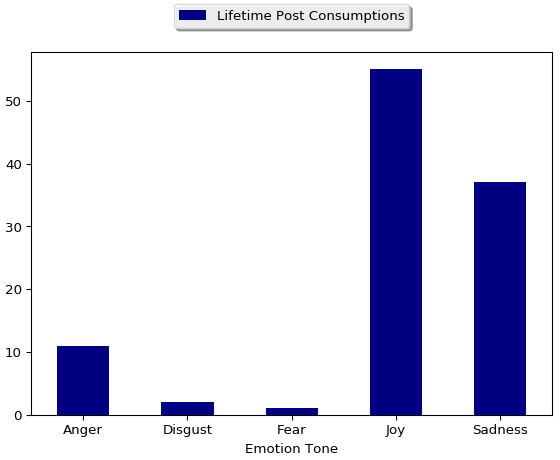

In [43]:
display(tones)

#### We can use also use a pie chart to identify how post consumption was broken up by tone. 


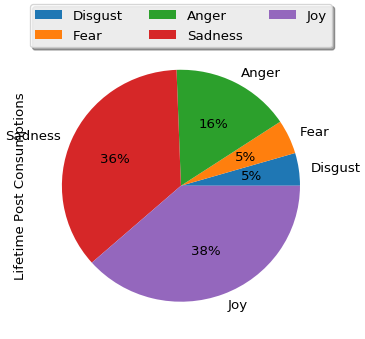

In [44]:
display(tones)

#### We can find out how mean post clicks differed by entity. 


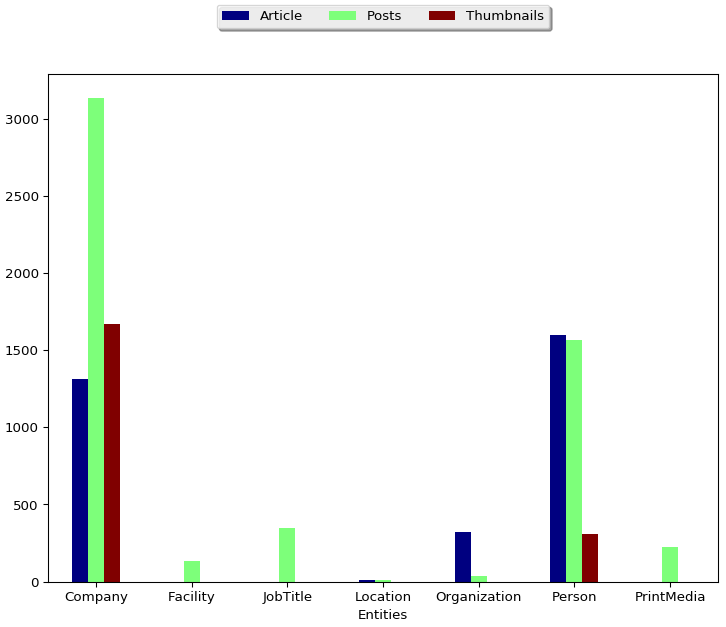

In [45]:
display(entities)

#### Finally we can see how post consumption was associated with certain keywords. 


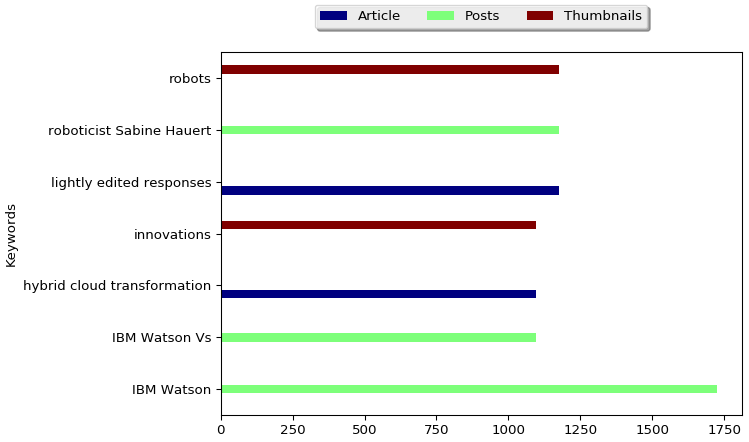

In [46]:
display(keywords)

# More Info.
For more information about PixieDust check out the following:
#### PixieDust Documentation: https://ibm-cds-labs.github.io/pixiedust/index.html
#### PixieDust GitHub Repo: https://github.com/ibm-cds-labs/pixiedust